In [ ]:
from fastai.vision.all import *
import cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter


In [145]:
# --- A) Gray World White Balance ---
class GrayWorldWB(Transform):
    order = 3
    def __init__(self, p=0.5, final_size=256, debug=False): 
        self.p, self.final_size, self.debug = p, final_size, debug
    def encodes(self, img:PILImage):
        if random.random() > self.p:
            if self.debug: print("[GrayWorldWB] skipped (random p)")
            return Resize(self.final_size)(img)
        a = np.array(img.convert('RGB')).astype(np.float32)
        means = a.reshape(-1,3).mean(0)

        imbalance = (abs(means[0]-means[1]) + abs(means[1]-means[2]))/means.mean()
        if imbalance < 0.2:
            if self.debug: print("[GrayWorldWB] skipped (low imbalance)")
            return Resize(self.final_size)(img)

        scale = means.mean() / (means+1e-6)
        wb = np.clip(a * scale, 0, 255).astype(np.uint8)
        pil = PILImage.create(wb)
        return Resize(self.final_size)(pil)


# --- B) Leaf Mask + Crop ---
class LeafMaskRefine(Transform):
    order = 4
    def __init__(self, pad=0.10, p=1.0, final_size=256, debug=False): 
        self.pad,self.p,self.final_size,self.debug = pad,p,final_size,debug
    def encodes(self, img:PILImage):
        if random.random() > self.p:
            if self.debug: print("[LeafMaskRefine] skipped (random p)")
            return Resize(self.final_size)(img)
        try:
            a = np.array(img.convert('RGB'))
            hsv = cv2.cvtColor(a, cv2.COLOR_RGB2HSV)
            H,S,V = cv2.split(hsv)
            green = ((H>=30)&(H<=95)&(S>40)&(V>40)).astype(np.uint8)
            if green.sum() == 0: 
                if self.debug: print("[LeafMaskRefine] fallback (no green mask)")
                return Resize(self.final_size)(img)

            exg = (2*a[:,:,1] - a[:,:,0] - a[:,:,2]).astype(np.float32)
            m0 = (exg > np.quantile(exg[green>0], 0.30)).astype(np.uint8)*255
            m0 = cv2.morphologyEx(m0, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
            m0 = cv2.morphologyEx(m0, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

            mask = np.where(m0>0, cv2.GC_PR_FGD, cv2.GC_BGD).astype('uint8')
            bgd, fgd = np.zeros((1,65),np.float64), np.zeros((1,65),np.float64)
            rect = (1,1,a.shape[1]-2,a.shape[0]-2)
            try: cv2.grabCut(a, mask, rect, bgd, fgd, 3, cv2.GC_INIT_WITH_MASK)
            except Exception: pass

            leaf = np.where((mask==cv2.GC_FGD)|(mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')
            cnts,_ = cv2.findContours(leaf, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: 
                if self.debug: print("[LeafMaskRefine] fallback (no contours)")
                return Resize(self.final_size)(img)

            x,y,w,h = cv2.boundingRect(max(cnts,key=cv2.contourArea))
            if w*h < 0.3*a.shape[0]*a.shape[1]:  # require ≥30% coverage
                if self.debug: print("[LeafMaskRefine] fallback (too small)")
                return Resize(self.final_size)(img)

            px,py = int(self.pad*w), int(self.pad*h)
            x0,y0 = max(0,x-px), max(0,y-py); x1,y1 = min(a.shape[1],x+w+px), min(a.shape[0],y+h+py)
            out = a[y0:y1, x0:x1].copy()
            pil = PILImage.create(out)
            pil.leaf_mask = leaf[y0:y1, x0:x1]
        except Exception:
            if self.debug: print("[LeafMaskRefine] exception → fallback")
            pil = img
        return Resize(self.final_size)(pil)


# --- C) Suppress Skin / Background ---
class SuppressSkinAndBG(Transform):
    order = 5
    def __init__(self, blur_bg=True, blur_ks=7, p=0.6, final_size=256, debug=False):
        self.blur_bg,self.blur_ks,self.p,self.final_size,self.debug = blur_bg,blur_ks,p,final_size,debug
    def encodes(self, img:PILImage):
        if random.random() > self.p:
            if self.debug: print("[SuppressSkinAndBG] skipped (random p)")
            return Resize(self.final_size)(img)
        a = np.array(img.convert('RGB'))
        mask = getattr(img, 'leaf_mask', None)
        if mask is None:
            if self.debug: print("[SuppressSkinAndBG] fallback (no mask)")
            return Resize(self.final_size)(img)

        hsv = cv2.cvtColor(a, cv2.COLOR_RGB2HSV)
        H,S,V = cv2.split(hsv)
        skin = (((H<25)|(H>165))&(S>20)&(V>60)).astype(np.uint8)*255
        leaf = cv2.bitwise_and(mask, cv2.bitwise_not(skin))
        leaf = cv2.morphologyEx(leaf, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))

        if self.blur_bg and leaf.sum() > 0.5*mask.size:
            bg = cv2.GaussianBlur(a, (self.blur_ks,self.blur_ks), 0)
            leaf3 = cv2.merge([leaf,leaf,leaf])
            a = np.where(leaf3>0, a, bg)

        pil = PILImage.create(a)
        pil.leaf_mask = leaf
        return Resize(self.final_size)(pil)


# --- D) Smart Lesion Crop ---
class SmartLesionCrop(Transform):
    order = 6
    def __init__(self, p=0.7, min_area=1200, pad=0.08, final_size=256, debug=False):
        self.p,self.min_area,self.pad,self.final_size,self.debug = p,min_area,pad,final_size,debug
    def encodes(self, img:PILImage):
        if random.random() > self.p:
            if self.debug: print("[SmartLesionCrop] skipped (random p)")
            return Resize(self.final_size)(img)
        a = np.array(img.convert('RGB')).astype(np.int16)
        mask = getattr(img, 'leaf_mask', np.ones(a.shape[:2], np.uint8)*255)

        R,G,B = a[:,:,0], a[:,:,1], a[:,:,2]
        lab = cv2.cvtColor(np.uint8(np.clip(a,0,255)), cv2.COLOR_RGB2LAB)
        L,A,Bc = cv2.split(lab)

        brown = np.clip((R-G) + 0.5*(R-B), 0, None).astype(np.float32)
        dark  = (255-L).astype(np.float32)
        hsv = cv2.cvtColor(np.uint8(np.clip(a,0,255)), cv2.COLOR_RGB2HSV)
        H,S,V = cv2.split(hsv)
        yellow = ((H>=20)&(H<=40)&(S>40)&(V>80)).astype(np.float32)

        score = (0.9*brown + 0.7*dark + 0.4*yellow)
        score = cv2.GaussianBlur(score, (0,0), 5)
        score *= (mask>0).astype(np.float32)

        for q in (0.997, 0.994, 0.990, 0.985):
            if not np.any(score>0): break
            thr = np.quantile(score[mask>0], q)
            m = (score>=thr).astype(np.uint8)*255
            m = cv2.morphologyEx(m, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))
            m = cv2.dilate(m, np.ones((9,9),np.uint8), 2)
            cnts,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not cnts: continue
            x,y,w,h = cv2.boundingRect(max(cnts,key=cv2.contourArea))
            if w*h < self.min_area: continue

            if w < 0.4*a.shape[1] or h < 0.4*a.shape[0]:
                if self.debug: print("[SmartLesionCrop] fallback (too zoomed)")
                return Resize(self.final_size)(img)

            if x==0 or y==0 or (x+w)==a.shape[1] or (y+h)==a.shape[0]:
                if self.debug: print("[SmartLesionCrop] fallback (touching border)")
                return Resize(self.final_size)(img)

            px,py = int(self.pad*w), int(self.pad*h)
            x0,y0 = max(0,x-px), max(0,y-py); x1,y1 = min(a.shape[1],x+w+px), min(a.shape[0],y+h+py)
            crop = np.uint8(np.clip(a[y0:y1, x0:x1],0,255))

            if crop.std() < 10:
                if self.debug: print("[SmartLesionCrop] fallback (flat crop)")
                return Resize(self.final_size)(img)

            pil = PILImage.create(crop)
            return Resize(self.final_size)(pil)

        if self.debug: print("[SmartLesionCrop] fallback (no lesion found)")
        return Resize(self.final_size)(img)


# --- E) CLAHE Contrast ---
class CLAHEContrast(Transform):
    order = 7
    def __init__(self, p=0.5, final_size=256, debug=False):
        self.p,self.final_size,self.debug = p,final_size,debug
    def encodes(self, img:PILImage):
        if random.random() > self.p:
            if self.debug: print("[CLAHEContrast] skipped (random p)")
            return Resize(self.final_size)(img)
        a = np.array(img.convert('RGB'))
        hsv = cv2.cvtColor(a, cv2.COLOR_RGB2HSV)
        H,S,V = cv2.split(hsv)
        if S.mean() > 180:
            if self.debug: print("[CLAHEContrast] skipped (high saturation)")
            return Resize(self.final_size)(img)

        if V.std() > 40:  # already enough contrast
            if self.debug: print("[CLAHEContrast] skipped (high std)")
            return Resize(self.final_size)(img)

        lab = cv2.cvtColor(a, cv2.COLOR_RGB2LAB)
        L,A,B = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))  # softer
        L2 = clahe.apply(L)
        lab2 = cv2.merge((L2,A,B))
        out = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
        pil = PILImage.create(out)
        return Resize(self.final_size)(pil)




In [146]:
def lesion_heatmap(pil_img, alpha=0.45, box=True, leaf_mask=None):
    """Highlight lesions within the leaf region only."""
    a = np.array(pil_img.convert('RGB')).astype(np.int16)
    R,G,B = a[:,:,0], a[:,:,1], a[:,:,2]

    # Brownness
    brown = np.clip((R-G) + 0.5*(R-B), 0, None).astype(np.float32)

    # Darkness (from LAB)
    lab = cv2.cvtColor(np.uint8(np.clip(a,0,255)), cv2.COLOR_RGB2LAB)
    L,A,Bc = cv2.split(lab)
    dark = (255-L).astype(np.float32)

    # Yellowing (from HSV)
    hsv = cv2.cvtColor(np.uint8(np.clip(a,0,255)), cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(hsv)
    yellow = ((H>=20)&(H<=40)&(S>40)&(V>80)).astype(np.float32)

    # Combined lesion score
    score = 0.7*brown + 0.6*dark + 0.5*yellow
    score = cv2.GaussianBlur(score, (0,0), 5)

    # ✅ Restrict to leaf area only
    if leaf_mask is None:
        leaf_mask = np.ones(a.shape[:2], np.uint8)*255
    score *= (leaf_mask > 0).astype(np.float32)

    # Normalize within the leaf only
    valid = score[leaf_mask>0]
    if valid.size > 0:
        s = (score - valid.min()) / (valid.max() - valid.min() + 1e-6)
    else:
        s = np.zeros_like(score)

    # Heatmap overlay
    heat = np.uint8(255 * s)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = np.uint8((1-alpha)*a + alpha*heat)

    # Bounding box (within leaf)
    if box and valid.size > 0:
        thr = np.quantile(valid, 0.98)  # top 2% pixels in leaf
        mask = (s >= thr).astype(np.uint8)*255
        mask = cv2.bitwise_and(mask, mask, mask=leaf_mask)
        cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cnts:
            x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
            cv2.rectangle(overlay, (x,y), (x+w,y+h), (255,255,255), 2)

    return Image.fromarray(overlay), s



In [ ]:
# --- Item transforms pipeline ---
item_tfms = [
    GrayWorldWB(p=1.0, final_size=256),
    LeafMaskRefine(p=1.0, final_size=256),
    SuppressSkinAndBG(blur_bg=True, p=1.0, final_size=256),
    SmartLesionCrop(p=0.8, final_size=256),
    CLAHEContrast(p=1.0),
    Resize(256)   # safety net to guarantee uniform size
]

# --- Batch transforms pipeline ---
batch_tfms = [
    *aug_transforms(
        min_scale=0.6,
        max_rotate=25, 
        max_zoom=1.2, 
        flip_vert=True,
        p_affine=0.9, 
        max_lighting=0.25, 
        p_lighting=0.9
    ),
    Normalize.from_stats(*imagenet_stats)
]

# --- DataLoaders ---
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=32,
    num_workers=0
)

# --- Visualize a batch ---
dls.show_batch(max_n=12, figsize=(10,10))






Class counts: Counter({'Early_Blight': 1400, 'Late_Blight': 1075, 'Pest': 498, 'Virus': 434, 'Bacteria': 406, 'Healthy': 277})


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\siddh/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.909765,0.912598,0.629158,0.601912,01:25


Better model found at epoch 0 with f1_score value: 0.6019119654424628.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.370549,0.815452,0.670254,0.643846,01:26
1,1.166167,0.722632,0.710372,0.685045,01:26
2,1.036328,0.618539,0.749511,0.729025,01:25
3,0.836429,0.524700,0.798434,0.781262,01:25
4,0.686869,0.463957,0.828767,0.812986,01:26
5,0.589636,0.422066,0.846380,0.826053,01:33
6,0.524563,0.397659,0.860078,0.837937,01:34
7,0.452920,0.372008,0.862035,0.846106,01:25
8,0.372689,0.359101,0.872798,0.854945,01:31
9,0.358582,0.359176,0.876712,0.863481,01:26


Better model found at epoch 0 with f1_score value: 0.643846232287394.
Better model found at epoch 1 with f1_score value: 0.6850452564226654.
Better model found at epoch 2 with f1_score value: 0.7290253879115182.
Better model found at epoch 3 with f1_score value: 0.7812618485030086.
Better model found at epoch 4 with f1_score value: 0.8129856052532055.
Better model found at epoch 5 with f1_score value: 0.826053133964216.
Better model found at epoch 6 with f1_score value: 0.83793656092689.
Better model found at epoch 7 with f1_score value: 0.846106214287995.
Better model found at epoch 8 with f1_score value: 0.8549454336441756.
Better model found at epoch 9 with f1_score value: 0.863480975978426.
Better model found at epoch 10 with f1_score value: 0.870627455241621.
Better model found at epoch 11 with f1_score value: 0.8829829962279817.
No improvement since epoch 11: early stopping
Checkpoints saved: 'best_model.pth', 'last_model.pth', 'final_model.pkl'


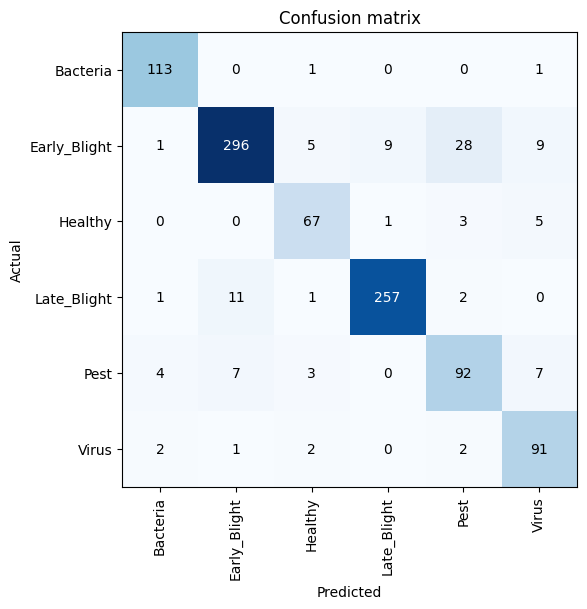

In [154]:

path = Path("Data")  # your dataset root (contains Bacteria/, Early_Blight/, etc.)

dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(256),   # resize before batching
    batch_tfms=[
        *aug_transforms(
            size=224,
            max_rotate=30,
            max_zoom=1.2,
            max_warp=0.2,
            max_lighting=0.3,
            p_affine=0.9,
            p_lighting=0.9
        ),
        Normalize.from_stats(*imagenet_stats)
    ],
    bs=32,
    num_workers=0
)

# -------------------------------
# 2. Class Weights (to handle imbalance)
# -------------------------------
labels = [dls.vocab[o[1]] for o in dls.train_ds]
counts = Counter(labels)
print("Class counts:", counts)

class_weights = torch.tensor(
    [1.0/counts[c] for c in dls.vocab], dtype=torch.float
)
loss_func = CrossEntropyLossFlat(weight=class_weights)

# -------------------------------
# 3. Callbacks
# -------------------------------
cbs = [
    SaveModelCallback(monitor='f1_score', comp=np.greater, fname='best_model'),
    EarlyStoppingCallback(monitor='f1_score', comp=np.greater, patience=5)
]

# -------------------------------
# 4. Model (ResNet34 to reduce overfitting)
# -------------------------------
learn = vision_learner(
    dls, resnet34,
    metrics=[accuracy, F1Score(average='macro')],
    loss_func=loss_func,
    cbs=cbs
)

# -------------------------------
# 5. (Optional) Find best learning rate
# -------------------------------
# learn.lr_find()

# -------------------------------
# 6. Train safely
# -------------------------------
try:
    learn.fine_tune(20, base_lr=3e-4)
except KeyboardInterrupt:
    print("Training interrupted — saving model.")
finally:
    learn.save('last_model')
    learn.export('final_model.pkl')
    print("Checkpoints saved: 'best_model.pth', 'last_model.pth', 'final_model.pkl'")

# -------------------------------
# 7. Evaluate
# -------------------------------
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))



In [155]:
from sklearn.metrics import classification_report, accuracy_score

# Get predictions and targets
preds, targs = learn.get_preds()

# Convert to labels
y_pred = preds.argmax(dim=1)
y_true = targs

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Detailed per-class metrics
print(classification_report(y_true, y_pred, target_names=dls.vocab))


Accuracy: 0.8962818003913894
              precision    recall  f1-score   support

    Bacteria       0.93      0.98      0.96       115
Early_Blight       0.94      0.85      0.89       348
     Healthy       0.85      0.88      0.86        76
 Late_Blight       0.96      0.94      0.95       272
        Pest       0.72      0.81      0.77       113
       Virus       0.81      0.93      0.86        98

    accuracy                           0.90      1022
   macro avg       0.87      0.90      0.88      1022
weighted avg       0.90      0.90      0.90      1022



In [156]:
def show_lesion_heatmap(img_path, alpha=0.65, box=True):
    """
    Show original leaf and lesion heatmap (brownness-based, leaf-masked).
    """
    # --- Load image ---
    pil_img = Image.open(img_path).convert('RGB')
    a = np.array(pil_img).astype(np.int16)
    R,G,B = a[:,:,0], a[:,:,1], a[:,:,2]

    # --- Step 1: Leaf mask (HSV + largest contour) ---
    hsv = cv2.cvtColor(np.uint8(np.clip(a,0,255)), cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(hsv)
    leaf_mask = ((H>=30)&(H<=95)&(S>40)&(V>40)).astype(np.uint8)*255
    leaf_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))

    cnts,_ = cv2.findContours(leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        leaf_mask = np.zeros_like(leaf_mask)
        cv2.drawContours(leaf_mask, [max(cnts,key=cv2.contourArea)], -1, 255, -1)

    # --- Step 2: Brownness score ---
    score = np.clip((R-G) + 0.5*(R-B), 0, None).astype(np.float32)
    score = cv2.GaussianBlur(score, (0,0), 5)

    # Restrict to leaf
    score *= (leaf_mask > 0).astype(np.float32)
    valid = score[leaf_mask>0]

    # --- Step 3: Normalize + gamma correction ---
    if valid.size > 0:
        s = (score - valid.min()) / (valid.max() - valid.min() + 1e-6)
        s = np.power(s, 0.5)  # gamma < 1 → highlights lesions more
    else:
        s = np.zeros_like(score)

    # --- Step 4: Heatmap overlay ---
    heat = np.uint8(255 * s)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = np.uint8((1-alpha)*a + alpha*heat)

    # --- Step 5: Optional bounding box around hottest region ---
    if box and valid.size > 0:
        thr = np.quantile(valid, 0.95)
        mask = (s >= thr).astype(np.uint8)*255
        cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cnts:
            x,y,w,h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
            cv2.rectangle(overlay, (x,y), (x+w,y+h), (255,255,255), 2)

    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(pil_img); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Lesion Heatmap (Brownness + Leaf Mask)"); plt.axis('off')
    plt.show()

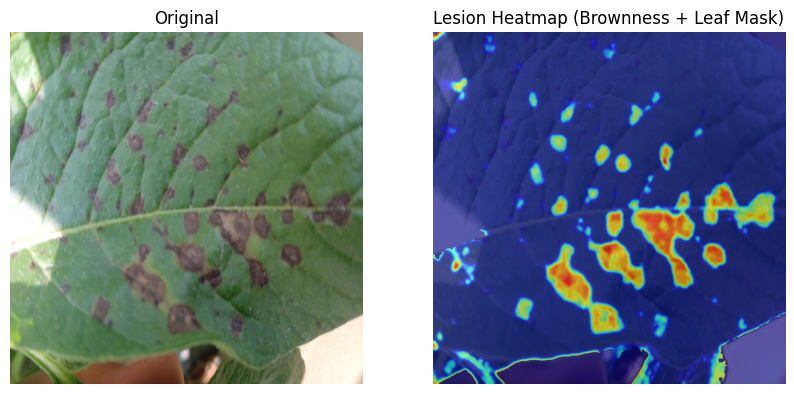

In [158]:
# Change this to any leaf image path
img_path = r"D:\Hackathon\disease_modelTrainer\Data\Early_Blight\Early_Blight_ (753).jpg"
show_lesion_heatmap(img_path)
